# Making WFI Mosaics with RomanCal

***

In [1]:
import roman_datamodels as rdm
from romancal.pipeline import MosaicPipeline
from romancal.associations import asn_from_list
from astropy.visualization import simple_norm
import json
import matplotlib.pyplot as plt

## Introduction
The purpose of this notebook is to combine Level 2 (L2; calibrated rate image) data products into a Level 3 (L3; distortion-corrected, co-added image) product. Details about the Roman data levels can be found [here](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products). The pipeline for combining images is called the Mosaic Pipeline. Please review the [RDox pages](https://roman-docs.stsci.edu/data-handbook-home/roman-stsci-data-pipelines/mosaic-level-pipeline) for details. It consists of the following steps:

1. **Flux step:** Transform instrumental units of data numbers per second (DN/s) into physical surface brightness units of megaJanskys per steradian (MJy/sr).
2. **Skymatch step:** Determine scaling factors necessary to match the flux levels in the overlapping sections of the input images. The images will be scaled by these factors later during the combination process.
3. **Outlier detection step:** Examine the input images to detect and flag outliers in the pixel values for a given sky position.
4. **Resample step:** Use the drizzle algorithm to combine the input data products. Reject outliers and other undesirable pixels based on data quality flags and oversample the pixels if indicated.

**Note:** L3 data products in the Roman Archive will be tessellated on the sky such that individual L3 files ("sky cells") will be small with some overlap between adjacent cells. More information is available on the [RDox pages on sky tessellation](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/skymap-tessellation). In this tutorial, we will not utilize tessellation. The tutorial will be updated in the future to demonstrate the creation of both tessellated and non-tessellated products.

***

## Making WFI Mosaics

### Generating the Association File

Association table files (often abbreviated "association files" or "ASN files") are JavaScript Object Notation (JSON) formatted files containing a list of the input products to be processed together, and the output products to be created. In the Mosaic Pipeline, association files specifically enumerate the input L2 products that are used to create a single L3 product. For more information, please visit the [RDox pages on association files](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products/associations).

The association generator function `asn_from_list()` can be used to create a properly formatted JavaScript Object Notation (JSON) file for use with the Mosaic Pipeline. The code takes as input a list of L2 products and the name of the L3 output product. You can include either one or many L2 products as input. For use cases that do use a single input file, you can skip several pipeline steps (skymatch and outlier_detection).

First, we can create the association JSON file using the `asn_from_list()` function:

In [2]:
# Collect our input files and make the L3 output filename
input_files = ['../data/r0000101001001001001_0001_wfi01_cal.asdf',]
product_name = 'my_roman_mosaic'

# Create the ASN JSON object
asn = asn_from_list.asn_from_list([(i, 'science') for i in input_files], 
                                  product_name=product_name, 
                                  with_exptype=True, target='')

Now let's take a look at the JSON object we just created. It should contain a listing of each of our input files as well as the output product name: 

In [3]:
asn

{
    "asn_type": "None",
    "asn_rule": "DMS_ELPP_Base",
    "version_id": null,
    "code_version": "0.20.2",
    "target": "",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "none",
    "skycell_wcs_info": "none",
    "products": [
        {
            "name": "my_roman_mosaic",
            "members": [
                {
                    "expname": "../data/r0000101001001001001_0001_wfi01_cal.asdf",
                    "exptype": "science"
                }
            ]
        }
    ]
}

We can also save the ASN file to disk:

In [4]:
# Write the ASN file to disk
_, serialized = asn.dump(format='json')
with open('my_roman_mosaic_asn.json', 'w') as f:
    f.write(serialized)

### Running the Mosaic Pipeline

Next we run the Mosaic Pipeline using the `MosaicPipeline` class. As with the L1 to L2 Exposure Pipeline, there are many optional arguments to customize the behavior of the pipeline. At this time, we will not delve into these optional parameters. The simulated input files are based on a simple gap-filling dither pattern rather than sub-pixel dithering optimized for the point spread function(PSF). As a result, we use the default native sampling of the WFI detectors. In the future, additional details may be provided to explore optimizing the Mosaic Pipeline output.

As we have only a single input image, this is where we skip the skymatch and outlier detection steps by passing the optional argument `steps={'skymatch': {'skip': True}, 'outlier_detection': {'skip': True}}`. Inaddition, we will skip the source catalog step that would normally make the single-band source catalog and segmentation map, which are Level 4 (L4; high-level extracted information) files.

**IMPORTANT NOTE:** At this time, L4 products are still being developed and validated, and we expect significant changes in their format and the algorithms used to generate them. We do not recommend the use of these products until they are fully validated.

**Note:** The following cell will take several minutes to complete.

In [5]:
result = MosaicPipeline.call('my_roman_mosaic_asn.json', save_results=True, steps={'source_catalog': {'skip': True}})

2025-09-13 00:46:39,020 - CRDS - ERROR -  Error determining best reference for 'pars-fluxstep'  =   No match found.
2025-09-13 00:46:39,024 - CRDS - ERROR -  Error determining best reference for 'pars-skymatchstep'  =   No match found.
2025-09-13 00:46:39,027 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  =   No match found.
2025-09-13 00:46:39,029 - CRDS - ERROR -  Error determining best reference for 'pars-resamplestep'  =   No match found.
2025-09-13 00:46:39,031 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'
2025-09-13 00:46:39,033 - CRDS - ERROR -  Error determining best reference for 'pars-mosaicpipeline'  =   Unknown reference type 'pars-mosaicpipeline'
2025-09-13 00:46:39,043 - stpipe.MosaicPipeline - INFO - MosaicPipeline instance created.
2025-09-13 00:46:39,044 - stpipe.MosaicPipeline.flux - INFO - FluxStep instance created.
2025-09-13 00:46:39,046 - stp

Now let's open the mosaic file we've created and take a look at what's inside:

In [6]:
mos_file = rdm.open('my_roman_mosaic_coadd.asdf')
mos_file.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode)
│   ├─0 (ExtensionMetadata) ...
│   ├─1 (ExtensionMetadata) ...
│   ├─2 (ExtensionMetadata) ...
│   ├─3 (ExtensionMetadata) ...
│   ├─4 (ExtensionMetadata) ...
│   └─3 not shown
└─roman (WfiMosaic) # The schema for WFI Level 3 mosaics.
  ├─meta (AsdfDictNode) # Common Level 3 Metadata ...
  ├─data (NDArrayType) # Science Data (MJy / steradian) ...
  ├─context (NDArrayType) # Context Data ...
  ├─err (NDArrayType) # Error Data (MJy / steradian) ...
  ├─weight (NDArrayType) # Weight Data ...
  ├─var_poisson (NDArrayType) # Poisson Variability (MJy^2 / steradian^2) ...
  ├─var_rnoise (NDArrayType) # Read Noise Variance (MJy^2 / steradian^2 ...
  └─individual_image_cal_logs (AsdfListNode) ...
Some nodes not shown.


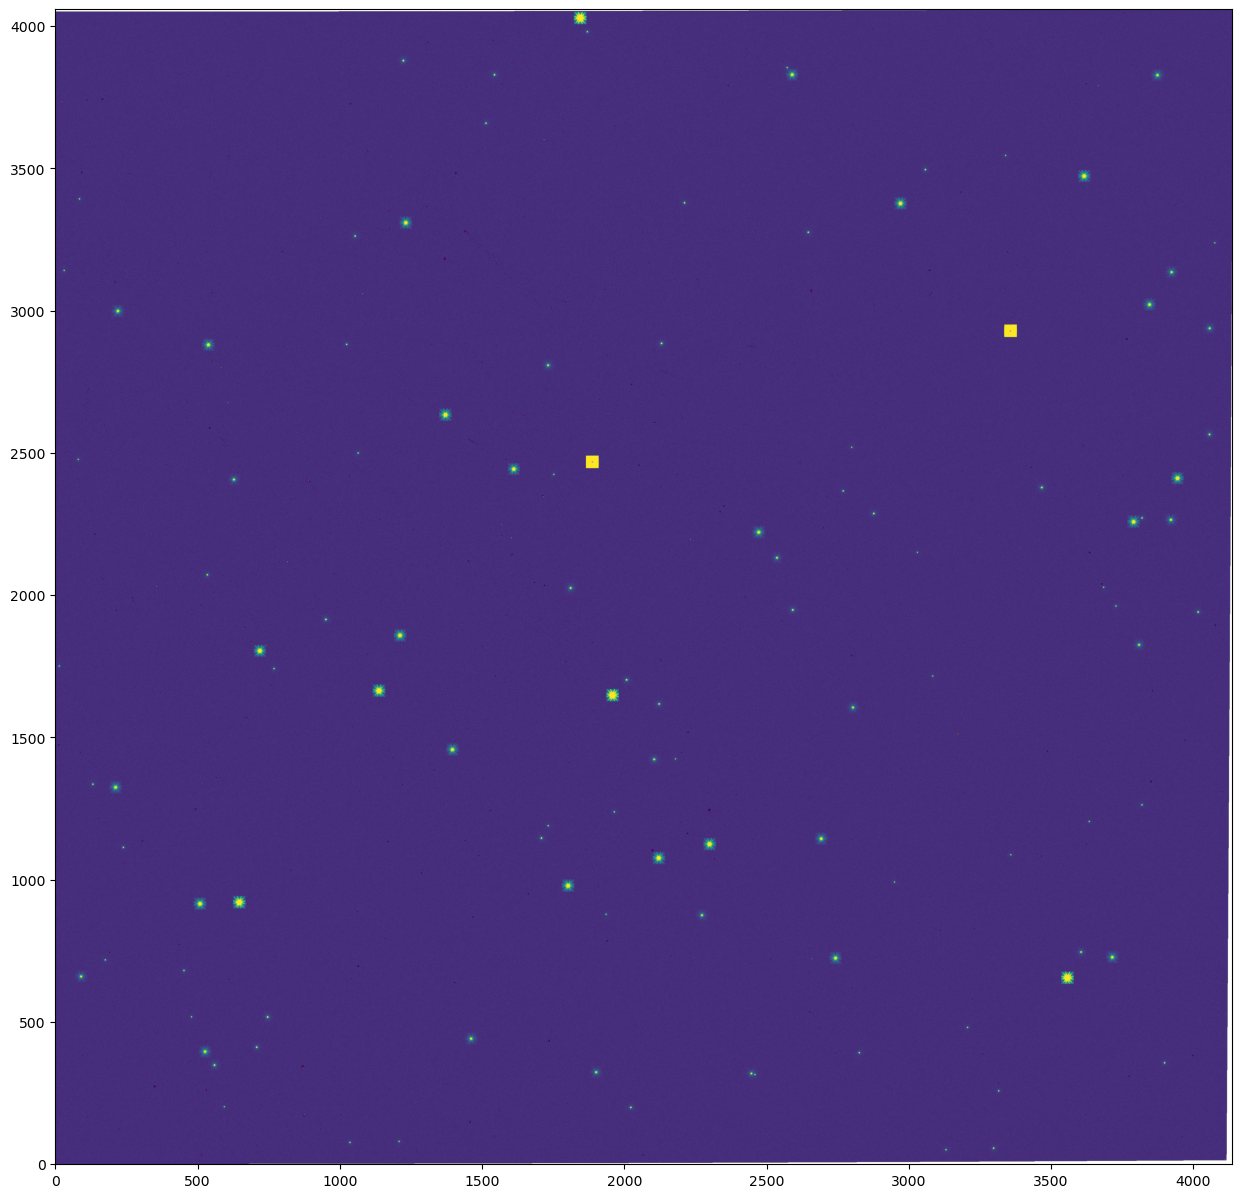

In [7]:
norm = simple_norm(mos_file.data, 'asinh', vmin=0.01, vmax=3.5)
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(mos_file.data, origin='lower', norm=norm)

An L3 file contains several extensions that may be of interest:
- data: The mosiac image in units of MegaJanskys per steradian
- context: An image showing the input images that contributed to each output pixel
- err: The error image
- weight: A weight map showing the relative coverage on the sky from the input images and how they contributed to the final mosaic

For more information on the how arrays are computed by the drizzle algorithm, we suggest consulting the [Resample Doc](https://roman-pipeline.readthedocs.io/en/latest/roman/resample/main.html). 

## Additional Resources
- [RomanCal Documentation](https://roman-pipeline.readthedocs.io/en/latest/index.html)
- [Roman Documentation](https://roman-docs.stsci.edu)
- [Resample Doc](https://roman-pipeline.readthedocs.io/en/latest/roman/resample/main.html)

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 